## Predicting What the Ideal Congress Member Looks Like


The dataset that I chose for this project is one from GovTrack that has collected data on current and historical legislators from 1789-Present. The information was scraped from several websites and all compiled into one dataset here: https://github.com/unitedstates/congress-legislators.

I combined the historical and the current and the final dataset that I used contains a total of 12516 rows and 15 columns. I dropped a fair amount of the columns ahead of time because about half of them were different ID's for each member. I kept data that was pertaining to their name, birthday, gender, party, etc. I also defined the Chinese Zodiac year for each candidate.

The end goal is to predict what an ideal candidate for each house will look like based on those features. I used several classification measures to determine this including Logistic Regression, Decision Trees, Random Forest, K-Nearest Neighbors, and XGBoost.


To start, I'm going to import the necessary libraries that I'll be using.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from xgboost import XGBClassifier

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder 

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set(style="white")
sns.set(style="darkgrid")
sns.set_palette('Set2')

**Define functions**

In [2]:
def chinese_signs(x):
    animal_signs = []
    for year in x.dt.year:
        if (year%12==7):
            animal_signs.append('Hare')
        elif (year%12==9):
            animal_signs.append('Snake')
        elif (year%12==10):
            animal_signs.append('Horse')
        elif (year%12==8):
            animal_signs.append('Dragon')
        elif (year%12==0):
            animal_signs.append('Monkey')
        elif (year%12==1):
            animal_signs.append('Rooster')
        elif (year%12==2):
            animal_signs.append('Dog')
        elif (year%12==3):
            animal_signs.append('Pig')
        elif (year%12==4):
            animal_signs.append('Rat')
        elif (year%12==5):
            animal_signs.append('Ox')
        elif (year%12==6):
            animal_signs.append('Tiger')
        else:
            animal_signs.append('Sheep')
    return animal_signs

In [3]:
def create_plot_of_feature_importances(model, X):
    ''' 
    Inputs: 
    
    model: A trained ensemble model instance
    X: a dataframe of the features used to train the model
    '''
    
    feat_importances = model.feature_importances_

    features_and_importances = zip(X.columns, feat_importances)
    features_and_importances = sorted(features_and_importances, 
                                     key = lambda x: x[1], reverse=True)
    
    features = [i[0] for i in features_and_importances]
    importances = [i[1] for i in features_and_importances]
    
    plt.figure(figsize=(10, 6))
    plt.barh(features, importances)
    plt.gca().invert_yaxis()
    plt.title('Feature Importances')
    plt.xlabel('importance')

## **Importing the Data:**

In [4]:
#Import data frames I'm going to use
df1 = pd.read_csv('legislators-current.csv')
df2 = pd.read_csv('legislators-historical.csv')
dfoffices = pd.read_csv('legislators-district-offices.csv')

## **Viewing the Data**

In [5]:
#Check out the columns
df1.columns

Index(['last_name', 'first_name', 'middle_name', 'suffix', 'nickname',
       'full_name', 'birthday', 'gender', 'type', 'state', 'district',
       'senate_class', 'party', 'url', 'address', 'phone', 'contact_form',
       'rss_url', 'twitter', 'facebook', 'youtube', 'youtube_id',
       'bioguide_id', 'thomas_id', 'opensecrets_id', 'lis_id', 'fec_ids',
       'cspan_id', 'govtrack_id', 'votesmart_id', 'ballotpedia_id',
       'washington_post_id', 'icpsr_id', 'wikipedia_id'],
      dtype='object')

In [6]:
df2.columns

Index(['last_name', 'first_name', 'middle_name', 'suffix', 'nickname',
       'full_name', 'birthday', 'gender', 'type', 'state', 'district',
       'senate_class', 'party', 'url', 'address', 'phone', 'contact_form',
       'rss_url', 'twitter', 'facebook', 'youtube', 'youtube_id',
       'bioguide_id', 'thomas_id', 'opensecrets_id', 'lis_id', 'fec_ids',
       'cspan_id', 'govtrack_id', 'votesmart_id', 'ballotpedia_id',
       'washington_post_id', 'icpsr_id', 'wikipedia_id'],
      dtype='object')

In [7]:
df = pd.concat([df1, df2], sort=False)

In [8]:
#Check out the final data frame columns
df.columns

Index(['last_name', 'first_name', 'middle_name', 'suffix', 'nickname',
       'full_name', 'birthday', 'gender', 'type', 'state', 'district',
       'senate_class', 'party', 'url', 'address', 'phone', 'contact_form',
       'rss_url', 'twitter', 'facebook', 'youtube', 'youtube_id',
       'bioguide_id', 'thomas_id', 'opensecrets_id', 'lis_id', 'fec_ids',
       'cspan_id', 'govtrack_id', 'votesmart_id', 'ballotpedia_id',
       'washington_post_id', 'icpsr_id', 'wikipedia_id'],
      dtype='object')

## **Clean the Data**

I'm going to start by dropping some of the data that I won't be needing. We can already see here that there are a lot of ID columns, I'm only to be keeping the bioguide_id.

In [9]:
#This is going to be the ID columns mostly plus some others like the phone number
df = df.drop(columns=['washington_post_id', 'wikipedia_id', 'youtube',
                     'youtube_id', 'votesmart_id', 'url', 'facebook',
                     'fec_ids', 'thomas_id', 'rss_url', 'opensecrets_id', 'senate_class',
                     'cspan_id', 'ballotpedia_id', 'contact_form', 'govtrack_id',
                     'icpsr_id', 'phone', 'lis_id'], axis=1)

# 'wikidata_id', 'fec_id', 'birthday_bio', 'suffix_name','official_full_name','nickname_name', 
# 'google_entity_id_id', 'gender_bio', 'house_history_id', 'maplight_id', 

In [10]:
#Let's see what the data looks like so we can start cleaning
print(df.info())
print('---------------------------------')
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12516 entries, 0 to 11978
Data columns (total 15 columns):
last_name      12516 non-null object
first_name     12516 non-null object
middle_name    8558 non-null object
suffix         440 non-null object
nickname       256 non-null object
full_name      882 non-null object
birthday       11963 non-null object
gender         12516 non-null object
type           12516 non-null object
state          12516 non-null object
district       10587 non-null float64
party          12282 non-null object
address        890 non-null object
twitter        529 non-null object
bioguide_id    12516 non-null object
dtypes: float64(1), object(14)
memory usage: 1.5+ MB
None
---------------------------------
(12516, 15)


In [11]:
#I'm going to look at the tail since they are the most current members
df.tail()

,last_name,first_name,middle_name,suffix,nickname,full_name,birthday,gender,type,state,district,party,address,twitter,bioguide_id
11974,Jones,Walter,B.,Jr.,NaN,Walter B. Jones,1943-02-10,M,rep,NC,3.0,Republican,2333 Rayburn House Office Building; Washington...,NaN,J000255
11975,Duffy,Sean,P.,NaN,NaN,Sean P. Duffy,1971-10-03,M,rep,WI,7.0,Republican,1714 Longworth House Office Building; Washingt...,NaN,D000614
11976,Collins,Chris,NaN,NaN,NaN,Chris Collins,1950-05-20,M,rep,NY,27.0,Republican,2243 Rayburn House Office Building; Washington...,NaN,C001092
11977,Cummings,Elijah,E.,NaN,NaN,Elijah E. Cummings,1951-01-18,M,rep,MD,7.0,Democrat,2163 Rayburn House Office Building; Washington...,NaN,C000984
11978,Hill,Katie,NaN,NaN,NaN,Katie Hill,1987-08-25,F,rep,CA,25.0,Democrat,1130 Longworth House Office Building; Washingt...,NaN,H001087


I'm now going to change some of the data to binary data. I'm going to add a new column dictating whether or not someone has a middle name or not, a suffix, a nick name, and a twitter account. I'm also going to change gender to be 1 or 0 as well as senators and representatives. I'm also going to fill in the missing district data to be 0. The current value of 0 in that column is at large districts, and so if there is no specified district, I'm going to assume there are no split districts in that area.

--1: Female, Senator, Yes/Has

--0: Male, House Representative, No/Does not have

In [12]:
#I'm going to add a new column changing some data to binary data
#Has {}, Female, senators: 1
#No {}, Male, representatives: 0
df['middlename'] = df['middle_name'].apply(lambda x: 1 if not pd.isnull(x) else 0)
df['nick_name'] = df['nickname'].apply(lambda x: 1 if not pd.isnull(x) else 0)
df['suffix2'] = df['suffix'].apply(lambda x: 1 if not pd.isnull(x) else 0)
df['gender'] = df['gender'].apply(lambda x: 1 if x=='F' else 0)
df['type'] = df['type'].apply(lambda x: 1 if x=='rep' else 0)
df['twitter'] = df['twitter'].apply(lambda x: 1 if not pd.isnull(x) else 0)
df['district'] = df['district'].fillna(0)

In [13]:
df.head()

,last_name,first_name,middle_name,suffix,nickname,full_name,birthday,gender,type,state,district,party,address,twitter,bioguide_id,middlename,nick_name,suffix2
0,Brown,Sherrod,NaN,NaN,NaN,Sherrod Brown,1952-11-09,0,0,OH,0.0,Democrat,503 Hart Senate Office Building Washington DC ...,1,B000944,0,0,0
1,Cantwell,Maria,NaN,NaN,NaN,Maria Cantwell,1958-10-13,1,0,WA,0.0,Democrat,511 Hart Senate Office Building Washington DC ...,1,C000127,0,0,0
2,Cardin,Benjamin,L.,NaN,NaN,Benjamin L. Cardin,1943-10-05,0,0,MD,0.0,Democrat,509 Hart Senate Office Building Washington DC ...,1,C000141,1,0,0
3,Carper,Thomas,Richard,NaN,NaN,Thomas R. Carper,1947-01-23,0,0,DE,0.0,Democrat,513 Hart Senate Office Building Washington DC ...,1,C000174,1,0,0
4,Casey,Robert,P.,Jr.,Bob,"Robert P. Casey, Jr.",1960-04-13,0,0,PA,0.0,Democrat,393 Russell Senate Office Building Washington ...,1,C001070,1,1,1


I now want to narrow down the party column so that it's more releveant to current times since you don't see many Whigs running for Congress anymore.

In [14]:
#Cast as string because some are floats for some reason
df['party'] = df['party'].astype(str)

In [15]:
#See how many of each so we can group them better.
pd.value_counts(df['party'])

Democrat                      5287
Republican                    5132
Whig                           564
Federalist                     343
Jackson                        338
nan                            234
Adams                           99
Ind. Republican-Democrat        70
American                        44
Populist                        42
Unionist                        42
Anti Jacksonian                 31
Anti Masonic                    27
Independent                     24
Ind. Democrat                   23
National Greenbacker            18
Unconditional Unionist          16
Anti-Jacksonian                 14
Farmer-Labor                    13
Ind. Republican                 13
Progressive                     12
Liberal Republican              12
Pro-Administration              12
Jacksonian                       9
Anti-Administration              9
Nullifier                        9
Conservative                     9
Anti-Lecompton Democrat          7
Free Soil           

As predicted, since republican and democrats far outweigh the rest of the parties, I'm going to separate the data into Dem, Rep, and Other.

In [16]:
partycount = df['party'].value_counts()
df['partisan'] = np.where(df['party'].isin(partycount.index[partycount < 1000]),
                               'Other', df['party'])
pd.value_counts(df['partisan'])

Democrat      5287
Republican    5132
Other         2097
Name: partisan, dtype: int64

I'm now going to change birthdays to be in the datetime format so that we can do something with that later.

In [17]:
#I'm also going to change birthdays into datetime so I can play with those a little later.
df['birthday'] = pd.to_datetime(df['birthday'])
type(df['birthday'])

pandas.core.series.Series

In [18]:
#Check everything again before I make a new dataframe with info I want to use
df.info()
#I'm also going to change the name so I can keep using df for the new one.
#But I don't want to rename everything up top.
dfold = df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12516 entries, 0 to 11978
Data columns (total 19 columns):
last_name      12516 non-null object
first_name     12516 non-null object
middle_name    8558 non-null object
suffix         440 non-null object
nickname       256 non-null object
full_name      882 non-null object
birthday       11963 non-null datetime64[ns]
gender         12516 non-null int64
type           12516 non-null int64
state          12516 non-null object
district       12516 non-null float64
party          12516 non-null object
address        890 non-null object
twitter        12516 non-null int64
bioguide_id    12516 non-null object
middlename     12516 non-null int64
nick_name      12516 non-null int64
suffix2        12516 non-null int64
partisan       12516 non-null object
dtypes: datetime64[ns](1), float64(1), int64(6), object(11)
memory usage: 1.9+ MB


In [19]:
#I'm dropping the columns that are duplicated and that we aren't currently using
df = dfold.drop(columns=['middle_name', 'suffix', 'nickname', 'full_name', 'address',
                        'bioguide_id', 'party', 'address'], axis=1)

In [20]:
df.head()

,last_name,first_name,birthday,gender,type,state,district,twitter,middlename,nick_name,suffix2,partisan
0,Brown,Sherrod,1952-11-09,0,0,OH,0.0,1,0,0,0,Democrat
1,Cantwell,Maria,1958-10-13,1,0,WA,0.0,1,0,0,0,Democrat
2,Cardin,Benjamin,1943-10-05,0,0,MD,0.0,1,1,0,0,Democrat
3,Carper,Thomas,1947-01-23,0,0,DE,0.0,1,1,0,0,Democrat
4,Casey,Robert,1960-04-13,0,0,PA,0.0,1,1,1,1,Democrat


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12516 entries, 0 to 11978
Data columns (total 12 columns):
last_name     12516 non-null object
first_name    12516 non-null object
birthday      11963 non-null datetime64[ns]
gender        12516 non-null int64
type          12516 non-null int64
state         12516 non-null object
district      12516 non-null float64
twitter       12516 non-null int64
middlename    12516 non-null int64
nick_name     12516 non-null int64
suffix2       12516 non-null int64
partisan      12516 non-null object
dtypes: datetime64[ns](1), float64(1), int64(6), object(4)
memory usage: 1.2+ MB


Since the only column that has missing data is birthday and there are still almost 12k rows without that information, I'm going to drop the rows that are missing it. I'm going to be using mostly the date data and so without that information, those rows won't be useful to us anyways.

In [22]:
df = df.dropna(subset=['birthday'])

In [23]:
#I'm also going to add a month born, a day born column, and a column for the signs of the Chinese Zodiac
df['month'] = df.birthday.dt.month

In [24]:
df['day'] = df.birthday.dt.day

In [25]:
df['chinesezodiac'] = chinese_signs(df['birthday'])

Before moving on to graphing the data, I want to see how varied the gender is.

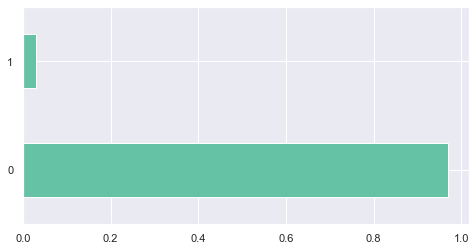

In [26]:
df['gender'].value_counts(normalize=True).plot(kind='barh', figsize=(8,4));

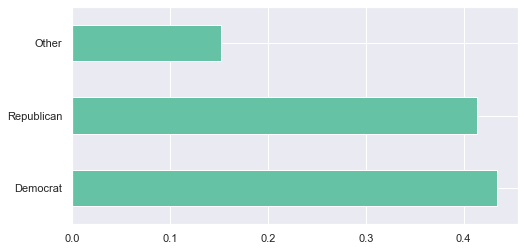

In [27]:
df['partisan'].value_counts(normalize=True).plot(kind='barh', figsize=(8,4));

As we can tell the Males far outweigh the females, and Democrats and Republicans far outweigh the other category. I am going to graph all of the data, however, keeping this in mind the data that are for males and one of the current main two parties will be the most accurate. We currently don't have any good data for current larger parties such as Libertarians as well as data for Congress Women and people of color. This data will become more available as more and more women, diverse races, and other parties get voted into Congress. Each Congress for the past several years has been more and more diverse both in gender and race than the Congresses before it so there is a trend upwards in this regard. For now, let's handle the data that we have now.

## **Graph the Data**

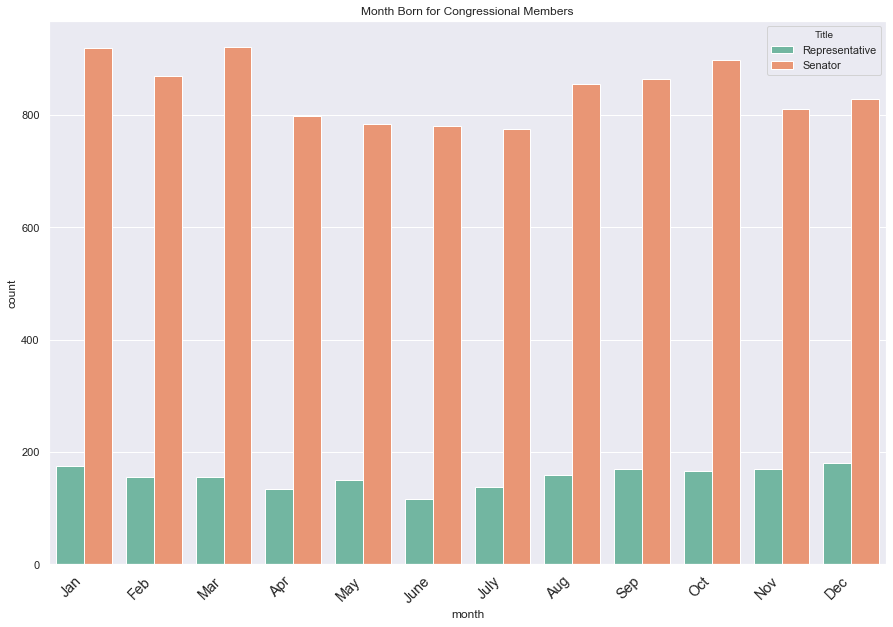

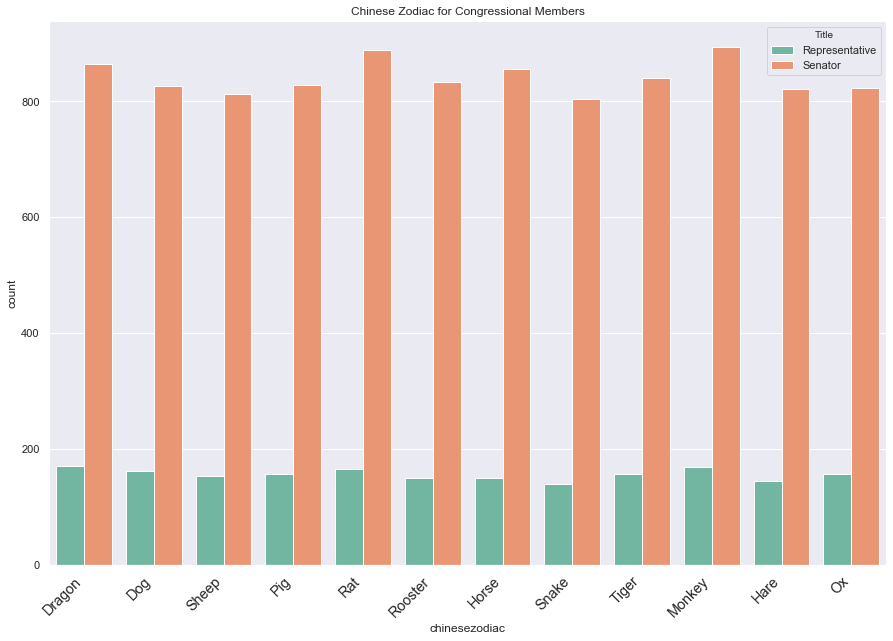

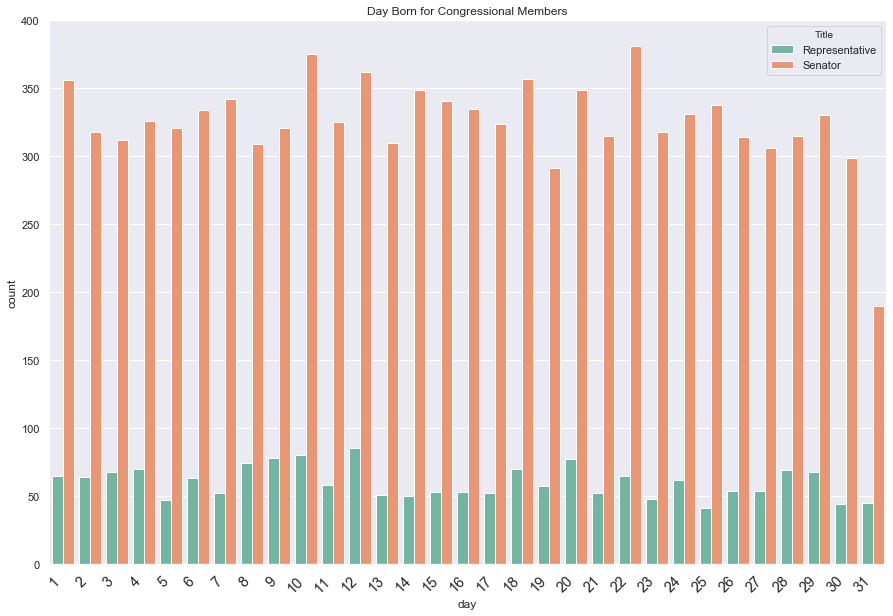

In [28]:
#Month born vs Title
fig, ax = plt.subplots(figsize = (15,10))
plt.title("Month Born for Congressional Members")
sns.countplot(x = "month", hue="type", data=df)
locs, labels = plt.xticks()
plt.xticks(locs, labels=('Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July',
         'Aug', 'Sep', 'Oct', 'Nov', 'Dec'),
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')
plt.legend(title='Title', loc='bottom left', labels=['Representative', 'Senator'])
plt.show()
#Chinese Zodiac features vs Title
plt.show()
fig, ax = plt.subplots(figsize = (15,10))
plt.title("Chinese Zodiac for Congressional Members")
sns.countplot(x = "chinesezodiac", hue="type", data=df)
locs, labels = plt.xticks()
plt.xticks(rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')
plt.legend(title='Title', loc='bottom left', labels=['Representative', 'Senator'])
plt.show()
#Day born vs Title
fig, ax = plt.subplots(figsize = (15,10))
plt.title("Day Born for Congressional Members")
sns.countplot(x = "day", hue="type", data=df)
locs, labels = plt.xticks()
plt.xticks(rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')
plt.legend(title='Title', loc='bottom left', labels=['Representative', 'Senator'])
plt.show()

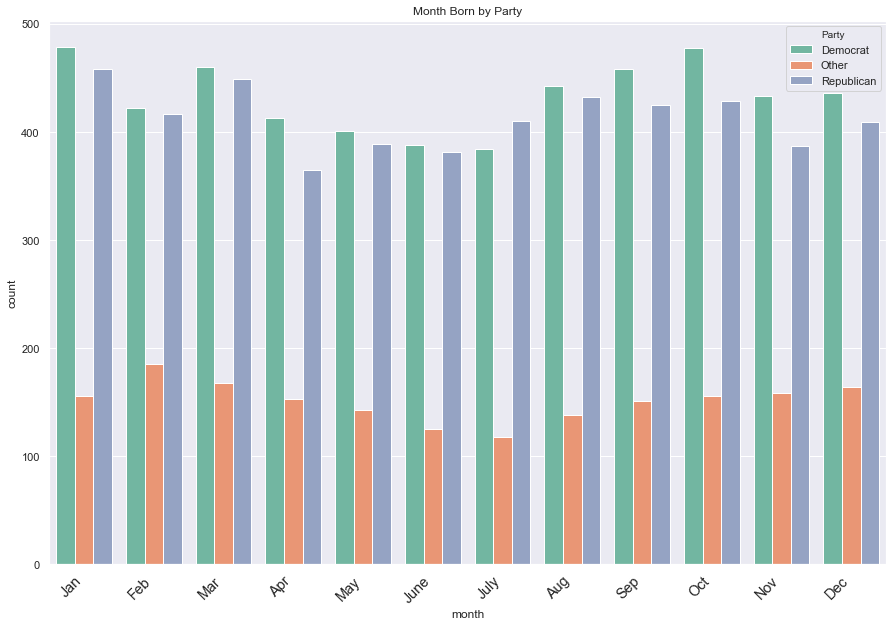

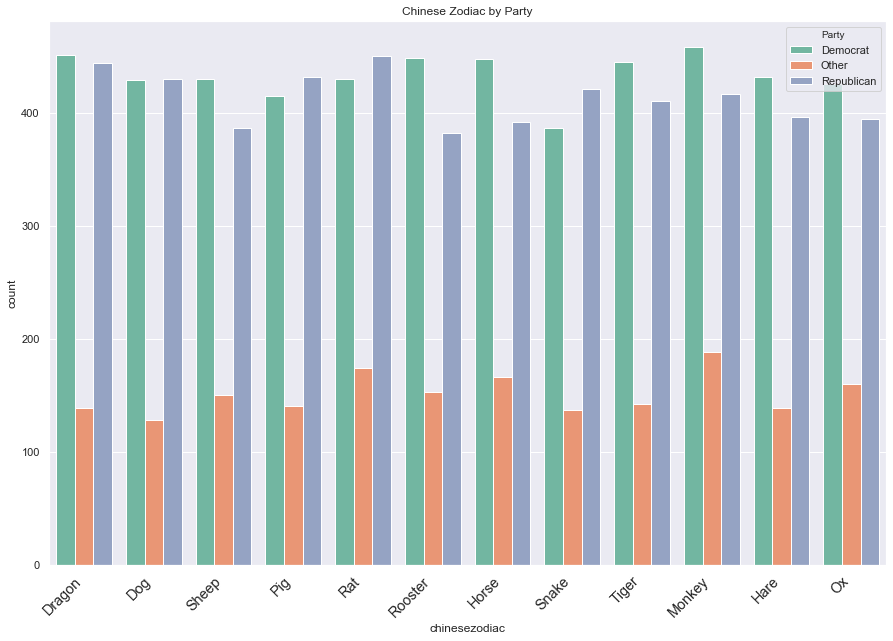

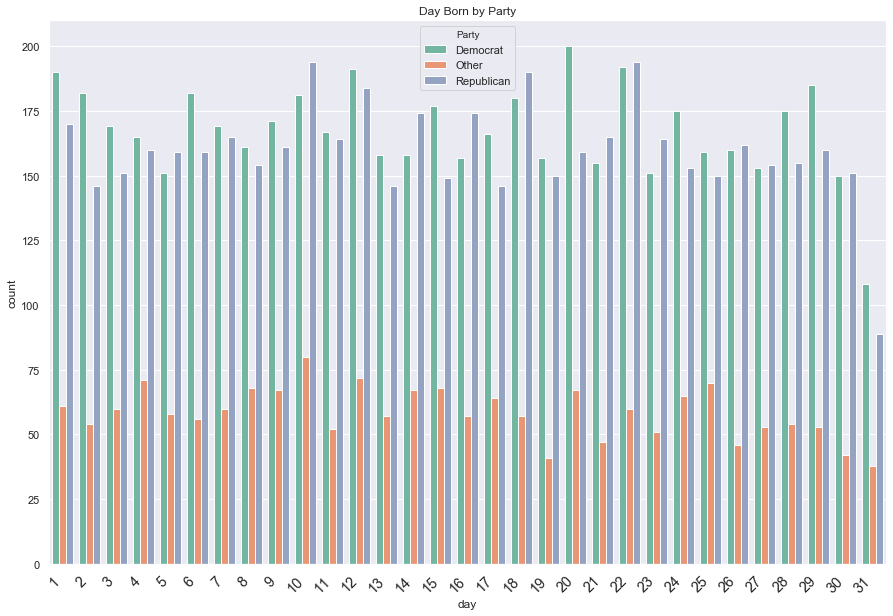

In [29]:
##Month born vs Party
fig, axes = plt.subplots(figsize = (15,10))
plt.title("Month Born by Party")
sns.countplot(x = "month", hue="partisan", data=df)
locs, labels = plt.xticks()
plt.xticks(locs, labels=('Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July',
         'Aug', 'Sep', 'Oct', 'Nov', 'Dec'),
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')
plt.legend(title='Party', loc='bottom left')
plt.show()


##Chinese Zodiac vs Party
fig, axes = plt.subplots(figsize = (15,10))
plt.title("Chinese Zodiac by Party")
sns.countplot(x = "chinesezodiac", hue="partisan", data=df)
locs, labels = plt.xticks()
plt.xticks(rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')
plt.legend(title='Party', loc='bottom left')
plt.show()


##Day born by Party
fig, axes = plt.subplots(figsize = (15,10))
plt.title("Day Born by Party")
sns.countplot(x = "day", hue="partisan", data=df)
locs, labels = plt.xticks()
plt.xticks(rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')
plt.legend(title='Party', loc='bottom left')
plt.show()

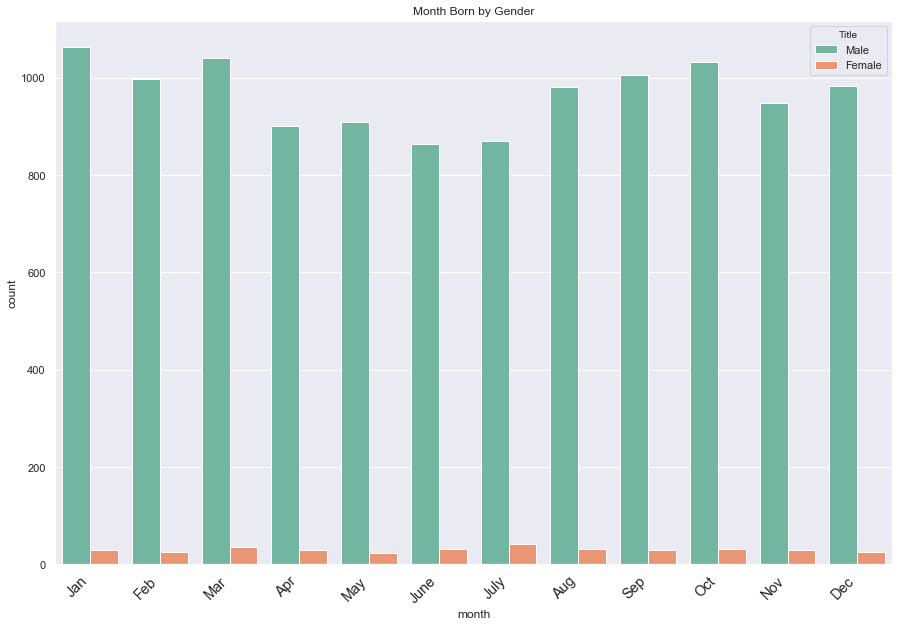

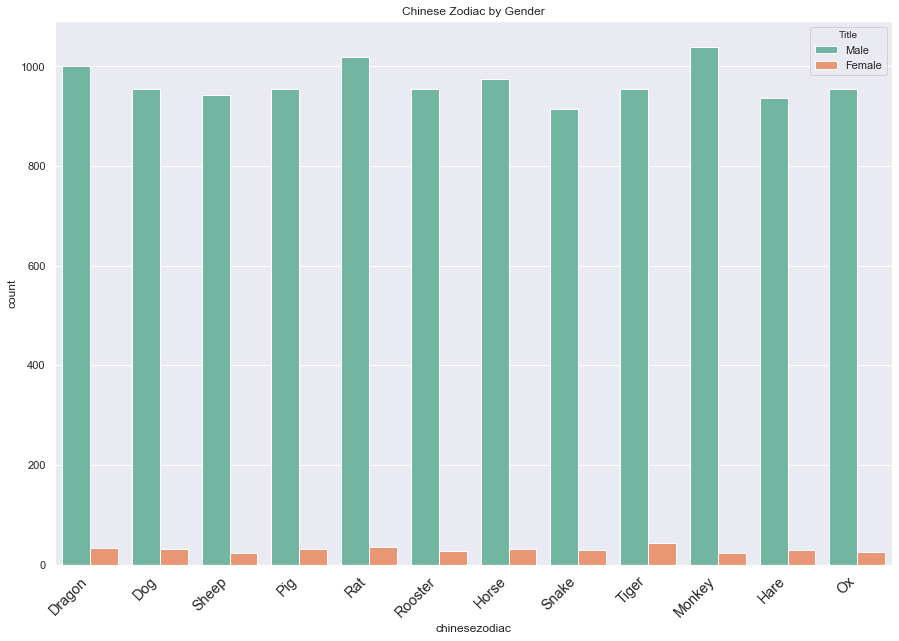

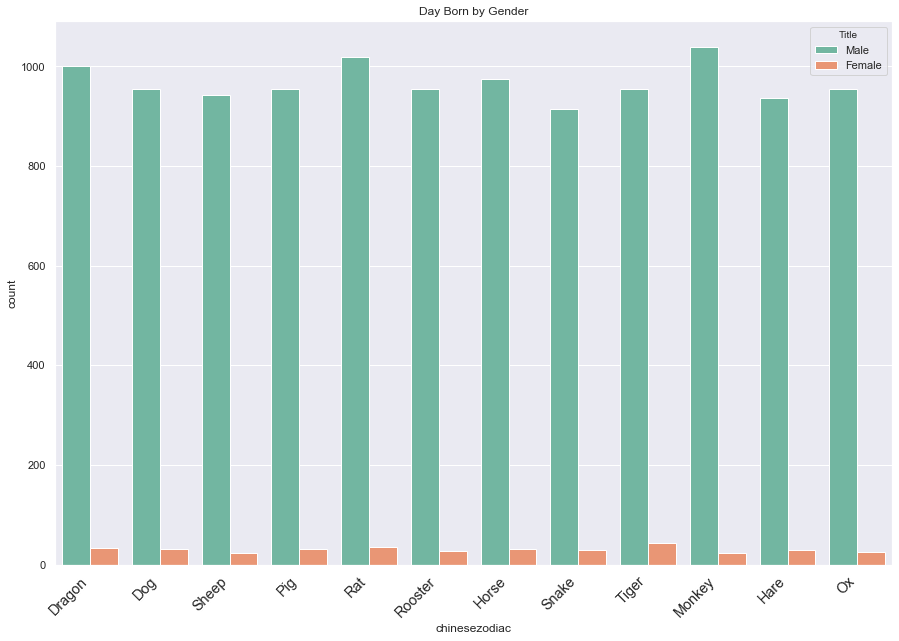

In [30]:
##Month Born vs Gender
fig, axes = plt.subplots(figsize = (15,10))
plt.title("Month Born by Gender")
sns.countplot(x = "month", hue="gender", data=df)
locs, labels = plt.xticks()
plt.xticks(locs, labels=('Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July',
         'Aug', 'Sep', 'Oct', 'Nov', 'Dec'),
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')
plt.legend(title='Title', loc='bottom left', labels=['Male', 'Female'])
plt.show()


##Chinese Zodiac vs Gender
fig, axes = plt.subplots(figsize = (15,10))
plt.title("Chinese Zodiac by Gender")
sns.countplot(x = "chinesezodiac", hue="gender", data=df)
locs, labels = plt.xticks()
plt.xticks(rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')
plt.legend(title='Title', loc='bottom left', labels=['Male', 'Female'])
plt.show()
fig, axes = plt.subplots(figsize = (15,10))


##Day Born by Gender
plt.title("Day Born by Gender")
sns.countplot(x = "chinesezodiac", hue="gender", data=df)
locs, labels = plt.xticks()
plt.xticks(rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')
plt.legend(title='Title', loc='bottom left', labels=['Male', 'Female'])
plt.show()

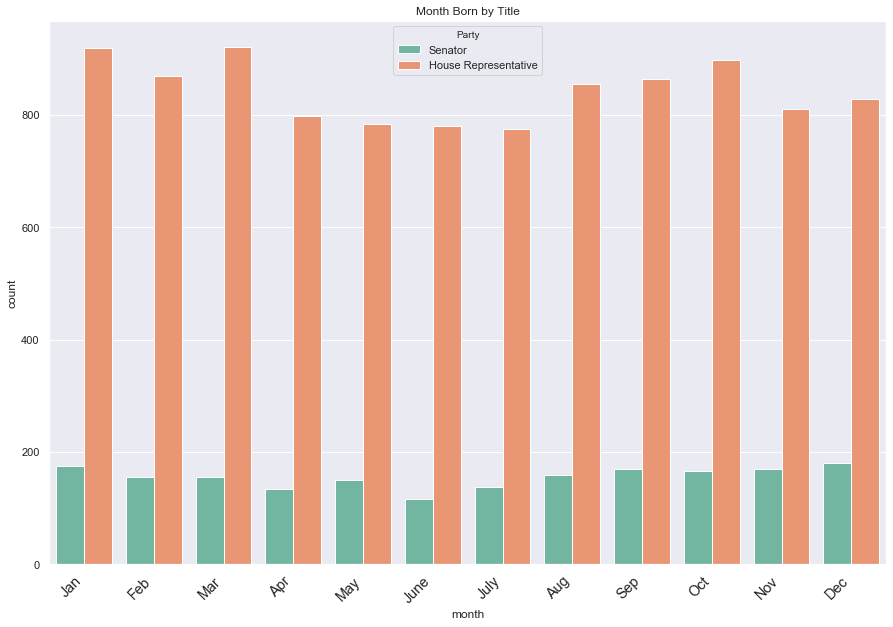

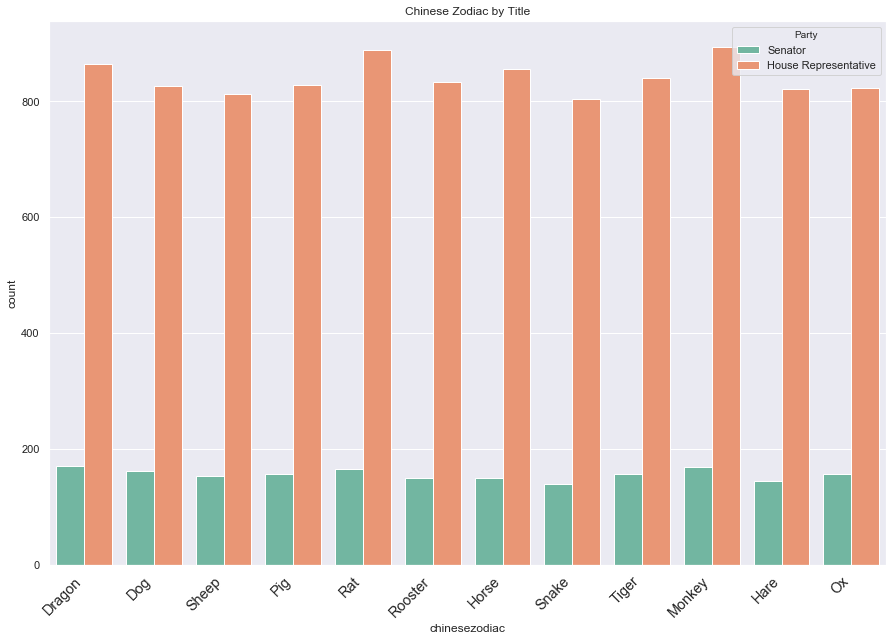

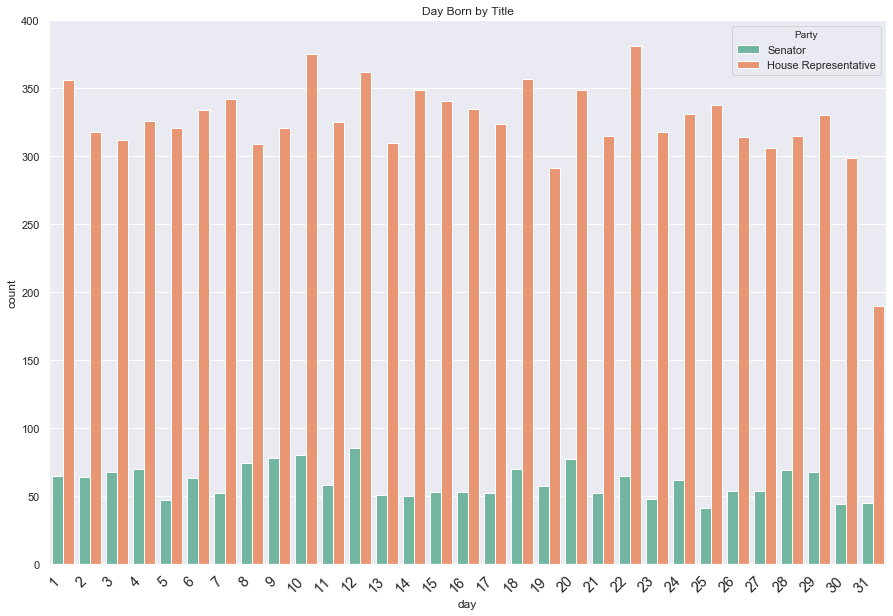

In [31]:
##Month born vs Type
fig, axes = plt.subplots(figsize = (15,10))
plt.title("Month Born by Title")
sns.countplot(x = "month", hue="type", data=df)
locs, labels = plt.xticks()
plt.xticks(locs, labels=('Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July',
         'Aug', 'Sep', 'Oct', 'Nov', 'Dec'),
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')
plt.legend(title='Party', loc='bottom left', labels=['Senator', 'House Representative'])
plt.show()


##Chinese Zodiac vs Type
fig, axes = plt.subplots(figsize = (15,10))
plt.title("Chinese Zodiac by Title")
sns.countplot(x = "chinesezodiac", hue="type", data=df)
locs, labels = plt.xticks()
plt.xticks(rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')
plt.legend(title='Party', loc='bottom left', labels=['Senator', 'House Representative'])
plt.show()


##Day born by Type
fig, axes = plt.subplots(figsize = (15,10))
plt.title("Day Born by Title")
sns.countplot(x = "day", hue="type", data=df)
locs, labels = plt.xticks()
plt.xticks(rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')
plt.legend(title='Party', loc='bottom left', labels=['Senator', 'House Representative'])
plt.show()

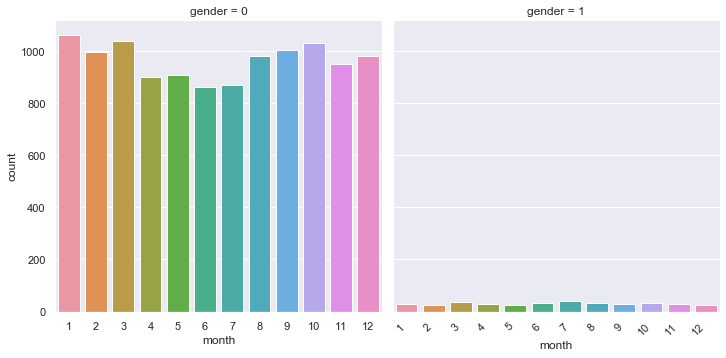

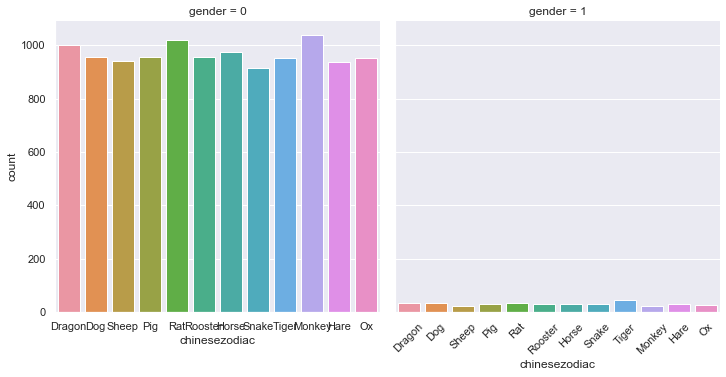

In [32]:
## Showing the Month that each gender was born in
sns.catplot(x = "month", data=df, col='gender', kind='count')
locs, labels = plt.xticks()
plt.xticks(rotation=45, 
    horizontalalignment='right',
    fontweight='light')
plt.show()

## Showing the Zodiac sign that each gender was born in
sns.catplot(x = "chinesezodiac", data=df, col='gender', kind='count')
locs, labels = plt.xticks()
plt.xticks(rotation=45, fontweight='light')
plt.show()

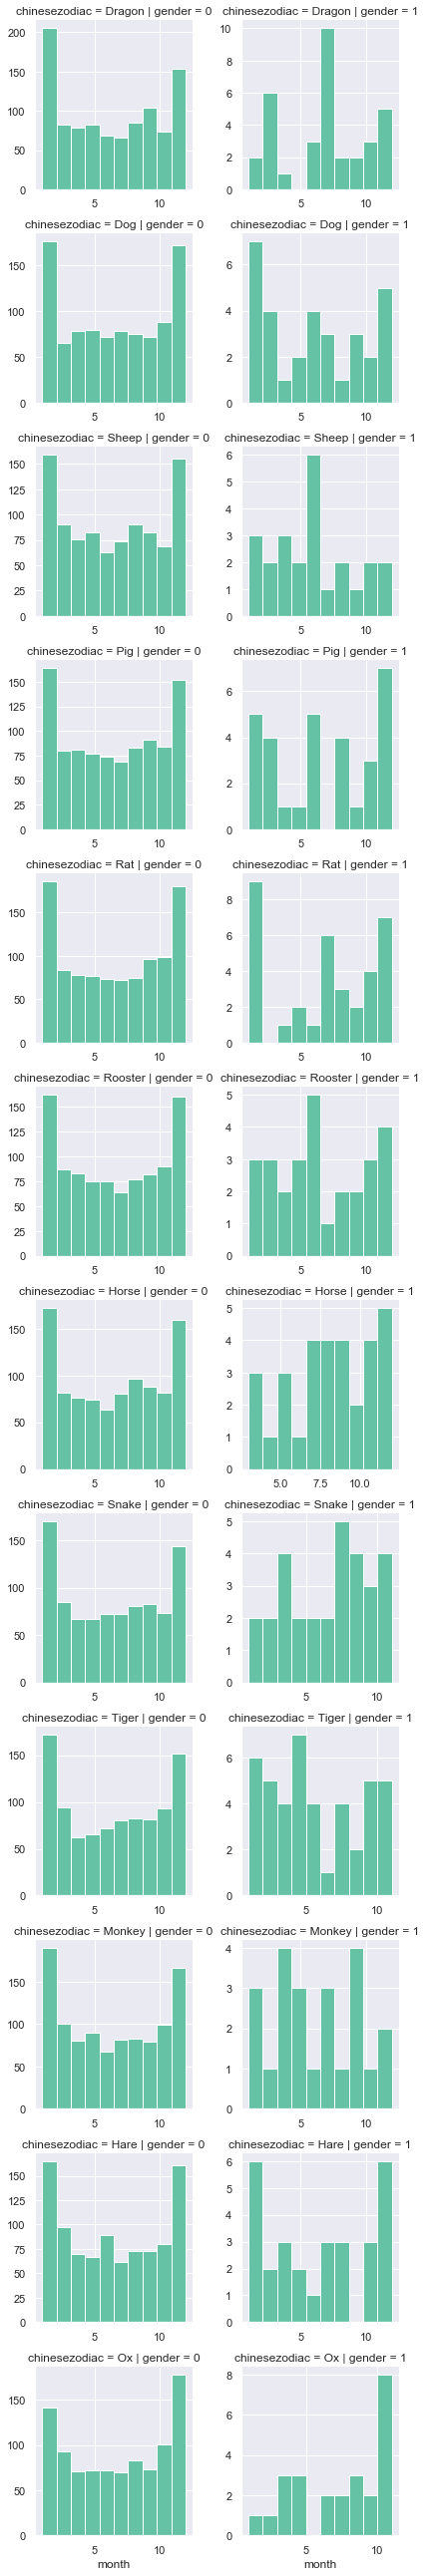

In [33]:
## Plot showing the month that each zodiac sign had someone born based on genders.
g = sns.FacetGrid(df, col="gender",  row="chinesezodiac", sharex=False, sharey=False)
g = g.map(plt.hist, 'month')

In [34]:
#Check out the header again before we start modeling
df.head()

,last_name,first_name,birthday,gender,type,state,district,twitter,middlename,nick_name,suffix2,partisan,month,day,chinesezodiac
0,Brown,Sherrod,1952-11-09,0,0,OH,0.0,1,0,0,0,Democrat,11,9,Dragon
1,Cantwell,Maria,1958-10-13,1,0,WA,0.0,1,0,0,0,Democrat,10,13,Dog
2,Cardin,Benjamin,1943-10-05,0,0,MD,0.0,1,1,0,0,Democrat,10,5,Sheep
3,Carper,Thomas,1947-01-23,0,0,DE,0.0,1,1,0,0,Democrat,1,23,Pig
4,Casey,Robert,1960-04-13,0,0,PA,0.0,1,1,1,1,Democrat,4,13,Rat


## **Modeling**

I'm going to start by getting the dataframe ready for modeling. This will include getting dummy variables for categorical data and making a new dataframe that drops features I won't be using.

In [35]:
#Make a new dataframe with the columns ready for use in model
## Dropping gender and Twitter for this because I don't want it to throw off my model.
dfmodel = df.drop(columns=['last_name', 'first_name', 'birthday', 'state', 'district', 'gender', 'twitter'],
                  axis=1)

In [36]:
#Get dummies for the features that are still categorical
dfmodel = pd.get_dummies(dfmodel, prefix_sep="__", columns=['chinesezodiac'])
dfmodel = pd.get_dummies(dfmodel, prefix_sep="__", columns=['partisan'])
dfmodel.head()

,type,middlename,nick_name,suffix2,month,day,chinesezodiac__Dog,chinesezodiac__Dragon,chinesezodiac__Hare,chinesezodiac__Horse,...,chinesezodiac__Ox,chinesezodiac__Pig,chinesezodiac__Rat,chinesezodiac__Rooster,chinesezodiac__Sheep,chinesezodiac__Snake,chinesezodiac__Tiger,partisan__Democrat,partisan__Other,partisan__Republican
0,0,0,0,0,11,9,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,10,13,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,1,0,0,10,5,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,0,1,0,0,1,23,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,0,1,1,1,4,13,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


**Logistic Regression** 


I'm first going to start with a simple machine learning classification model: Logitic Regression. This will provide a baseline model to how we can judge our accuracy.

First we will start by splitting our data:

In [37]:
#Define our features we're going to be using to find our target information of Senator vs Representative
X= dfmodel.drop(columns=['type'], axis=1)
y= dfmodel.type

#We're going to be saving a testing size of 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state =4)

#Name the classifier
logreg = LogisticRegression()

#fit the model
logreg.fit(X_train, y_train)

# predict
train_preds = logreg.predict(X_train)
test_preds = logreg.predict(X_test)

# evaluate
train_accuracy_logreg = accuracy_score(y_train, train_preds)
test_accuracy_logreg = accuracy_score(y_test, test_preds)
total_accuracy_logreg = accuracy_score(y_test, test_preds)
report_logreg = classification_report(y_test, test_preds)

print("Logistic Regression")
print("------------------------")
print(f"Training Accuracy: {(train_accuracy_logreg * 100):.4}%")
print(f"Test Accuracy:     {(test_accuracy_logreg * 100):.4}%")


Logistic Regression
------------------------
Training Accuracy: 84.11%
Test Accuracy:     85.01%


**Random Forest**

Next I'm going to fit a random forest classifier to the data.

In [38]:
#Set our features and training data again
X = dfmodel.drop(columns=['type'], axis=1)
y= dfmodel.type

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state =4)

I'm now going to fit a parameter grid to pass into a grid search so that we can find the best parameters to tune for our Random Forest classifer. After I fit the parameter grid, I'm going to run that in to the Grid Search and use the outcome to fit my Random Forest to the data.

In [39]:
#Define Parameter Grid Search
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [2, 4, 6, 8, 10, 12], 
              'min_samples_split': [3, 8, 13, 20], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 8]}

In [40]:
#Set Classifier
rfc = RandomForestClassifier()

In [41]:
#Perform Grid Search
cv_rfc = GridSearchCV(rfc, param_grid, cv=6)

cv_rfc.fit(X_train, y_train)

GridSearchCV(cv=6, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [42]:
#View the best results
cv_rfc.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [43]:
#Fit results to the Random Forest Classifer we'll be using
rfc = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [44]:
#Fit our model and show the accuracy
rfc.fit(X_train, y_train)

# predict
train_preds = rfc.predict(X_train)
test_preds = rfc.predict(X_test)

# evaluate
train_accuracy_rfc = accuracy_score(y_train, train_preds)
test_accuracy_rfc = accuracy_score(y_test, test_preds)
report_rfc = classification_report(y_test, test_preds)

print("Random Forest")
print("-------------------------")
print(f"Training Accuracy: {(train_accuracy_rfc * 100):.4}%")
print(f"Test Accuracy:     {(test_accuracy_rfc * 100):.4}%")

Random Forest
-------------------------
Training Accuracy: 84.11%
Test Accuracy:     85.01%


**XGBoost**

Now we're going to train a Gradient Boosting classifier called XGBoost. It is considered one of the most powerful classification algorithms out right now.

This is going to be done similar to Random Forest, in that we are going to set the classifier, set a parameter grid, and then re-run the model using the parameters that are best defined.

In [45]:
#Set our features and training data again
X = dfmodel.drop(columns=['type'], axis=1)
y= dfmodel.type

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state =4)

In [46]:
# Set classifier
booster = XGBClassifier()

# create parameter grid
param_grid = {'n_estimators': [100],
              'learning_rate': [0.05, 0.1], 
              'max_depth': [3, 5, 10],
              'colsample_bytree': [0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

# Run the grid search with our booster information
booster_grid_search = GridSearchCV(booster, param_grid, scoring='accuracy', cv=3, n_jobs=-1)

# train the tuned random forest
booster_grid_search.fit(X_train, y_train)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)

{'colsample_bytree': 0.7, 'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


In [47]:
#Set the tuned clasifier
booster = XGBClassifier(learning_rate=0.05, max_depth=3, n_estimators=100,
                            colsample_bytree=0.7, gamma=0.1)

# train
booster.fit(X_train, y_train)

# predict
train_preds = booster.predict(X_train)
test_preds = booster.predict(X_test)

# evaluate
train_accuracy_booster = accuracy_score(y_train, train_preds)
test_accuracy_booster = accuracy_score(y_test, test_preds)
report_booster = classification_report(y_test, test_preds)

print("XGBoost")
print("-------------------------")
print(f"Training Accuracy: {(train_accuracy_booster * 100):.4}%")
print(f"Test Accuracy:     {(test_accuracy_booster * 100):.4}%")

XGBoost
-------------------------
Training Accuracy: 84.11%
Test Accuracy:     85.01%


**K-Nearest Neighbors**

In [48]:
#Define our features we're going to be using to find our target information of Senator vs Representative
X= dfmodel.drop(columns=['type'], axis=1)
y= dfmodel.type

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state =4)

#Name the classifier
knn = KNeighborsClassifier()

#fit the model
knn.fit(X_train, y_train)

# predict
train_preds = knn.predict(X_train)
test_preds = knn.predict(X_test)

# evaluate
train_accuracy_knn = accuracy_score(y_train, train_preds)
test_accuracy_knn = accuracy_score(y_test, test_preds)
report_knn = classification_report(y_test, test_preds)

print("K-Nearest Neighbors")
print("------------------------")
print(f"Training Accuracy: {(train_accuracy_knn * 100):.4}%")
print(f"Test Accuracy:     {(test_accuracy_knn * 100):.4}%")

K-Nearest Neighbors
------------------------
Training Accuracy: 85.25%
Test Accuracy:     83.95%


Let's view all of the classification reports for our first run of models.

In [49]:
print('Classification Report XGBoost: \n', report_booster)
print('------------------------------------------------------')
print('Classification Report Logistic Regression: \n', report_logreg)
print('------------------------------------------------------')
print('Classification Report Random Forest: \n', report_rfc)
print('------------------------------------------------------')
print('Classification Report Random Forest: \n', report_knn)

Classification Report XGBoost: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       538
           1       0.85      1.00      0.92      3051

    accuracy                           0.85      3589
   macro avg       0.43      0.50      0.46      3589
weighted avg       0.72      0.85      0.78      3589

------------------------------------------------------
Classification Report Logistic Regression: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       538
           1       0.85      1.00      0.92      3051

    accuracy                           0.85      3589
   macro avg       0.43      0.50      0.46      3589
weighted avg       0.72      0.85      0.78      3589

------------------------------------------------------
Classification Report Random Forest: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       538
          

**Smote**

I'm not going to try to deal with some imbalance issues with our target feature of Senators vs Representatives by using SMOTE. Just as a refresher, this imbalance is natural in our data and will always remain imbalanced because there are more House Representatives at any given time vs the number of Senators at any given time in Congress.

In [50]:
#Set our features and training data again
X = dfmodel.drop(columns=['type'], axis=1)
y= dfmodel.type

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state =4)

# resample data with SMOTE using training data
X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train) 


# view previous class distribution
print(df['type'].value_counts()) 

# view SMOTE sample class distribution
print(pd.Series(y_resampled).value_counts())

1    10094
0     1869
Name: type, dtype: int64
1    7043
0    7043
dtype: int64


In [51]:
# Perform another train-test-split using the new resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3, random_state =4)

Now we're going to run all of our models again using the new information.

**Logistic Regression x2**

In [52]:
#Name the classifier
logreg2 = LogisticRegression()

#fit the model
logreg2.fit(X_train, y_train)

# predict
train_preds = logreg2.predict(X_train)
test_preds = logreg2.predict(X_test)

# evaluate
train_accuracy_logreg2 = accuracy_score(y_train, train_preds)
test_accuracy_logreg2 = accuracy_score(y_test, test_preds)
report_logreg2 = classification_report(y_test, test_preds)

print("Logistic Regression with SMOTE")
print("------------------------")
print(f"Training Accuracy: {(train_accuracy_logreg2 * 100):.4}%")
print(f"Test Accuracy:     {(test_accuracy_logreg2 * 100):.4}%")

Logistic Regression with SMOTE
------------------------
Training Accuracy: 83.14%
Test Accuracy:     83.32%


**Random Forest x2**

In [53]:
#Fit results to the Random Forest Classifer we'll be using
rfc2 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#Train the data again
rfc2.fit(X_train, y_train)

# predict
train_preds = rfc2.predict(X_train)
test_preds = rfc2.predict(X_test)

# evaluate
train_accuracy_rfc2 = accuracy_score(y_train, train_preds)
test_accuracy_rfc2 = accuracy_score(y_test, test_preds)
report_rfc2 = classification_report(y_test, test_preds)

print("Random Forest with SMOTE")
print("-------------------------")
print(f"Training Accuracy: {(train_accuracy_rfc2 * 100):.4}%")
print(f"Test Accuracy:     {(test_accuracy_rfc2 * 100):.4}%")

Random Forest with SMOTE
-------------------------
Training Accuracy: 82.61%
Test Accuracy:     80.0%


**XGBoost x2**

In [54]:
#Set the tuned clasifier
booster2 = XGBClassifier(learning_rate=0.05, max_depth=3, n_estimators=100,
                            colsample_bytree=0.7, gamma=0.1)

# train
booster2.fit(X_train, y_train)

# predict
train_preds = booster2.predict(X_train)
test_preds = booster2.predict(X_test)

# evaluate
train_accuracy_booster2 = accuracy_score(y_train, train_preds)
test_accuracy_booster2 = accuracy_score(y_test, test_preds)
report_booster2 = classification_report(y_test, test_preds)

print("XGBoost with SMOTE")
print("-------------------------")
print(f"Training Accuracy: {(train_accuracy_booster2 * 100):.4}%")
print(f"Test Accuracy:     {(test_accuracy_booster2 * 100):.4}%")

XGBoost with SMOTE
-------------------------
Training Accuracy: 82.32%
Test Accuracy:     81.76%


**K-Nearest Neighbors using SMOTE**

In [55]:
#Name the classifier
knn2 = KNeighborsClassifier()

#fit the model
knn2.fit(X_train, y_train)

# predict
train_preds = knn2.predict(X_train)
test_preds = knn2.predict(X_test)

# evaluate
train_accuracy_knn2 = accuracy_score(y_train, train_preds)
test_accuracy_knn2 = accuracy_score(y_test, test_preds)
report_knn2 = classification_report(y_test, test_preds)

print("K-Nearest Neighbors")
print("------------------------")
print(f"Training Accuracy: {(train_accuracy_knn2 * 100):.4}%")
print(f"Test Accuracy:     {(test_accuracy_knn2 * 100):.4}%")

K-Nearest Neighbors
------------------------
Training Accuracy: 76.61%
Test Accuracy:     67.04%


Let's view all of the classification reports again for our second run of models

In [56]:
print('Classification Report XGBoost with SMOTE: \n', report_booster2)
print('------------------------------------------------------')
print('Classification Report Logistic Regression with SMOTE: \n', report_logreg2)
print('------------------------------------------------------')
print('Classification Report Random Forest with SMOTE: \n', report_rfc2)
print('------------------------------------------------------')
print('Classification Report Random Forest with SMOTE: \n', report_knn2)

Classification Report XGBoost with SMOTE: 
               precision    recall  f1-score   support

           0       0.94      0.68      0.79      2092
           1       0.75      0.96      0.84      2134

    accuracy                           0.82      4226
   macro avg       0.84      0.82      0.81      4226
weighted avg       0.84      0.82      0.81      4226

------------------------------------------------------
Classification Report Logistic Regression with SMOTE: 
               precision    recall  f1-score   support

           0       1.00      0.66      0.80      2092
           1       0.75      1.00      0.86      2134

    accuracy                           0.83      4226
   macro avg       0.88      0.83      0.83      4226
weighted avg       0.87      0.83      0.83      4226

------------------------------------------------------
Classification Report Random Forest with SMOTE: 
               precision    recall  f1-score   support

           0       0.83      0.

**PCA**

PCA is a dimensionality reduction technique that we are going to implement to see if we can get a better model by reducing the dimensionality.

In [57]:
#Set the features and target and the testing data again.
#We're going to keep the SMOTE data for this.
X= dfmodel.drop(columns=['type'], axis=1)
y= dfmodel.type

X_resampled, y_resampled = SMOTE().fit_sample(X, y) 

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, 
                                                    test_size = 0.3)

In [58]:
pca = PCA(svd_solver='auto')
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

In [59]:
print(pca.explained_variance_ratio_)
print(pca.n_components_)

[8.46970431e-01 1.36257588e-01 4.51721879e-03 2.66029038e-03
 1.51185507e-03 7.58982054e-04 7.13750206e-04 6.90985089e-04
 6.80569639e-04 6.60833693e-04 6.54609070e-04 6.51850575e-04
 6.41936788e-04 6.35650186e-04 6.29297253e-04 5.82017361e-04
 2.62781346e-04 1.81037985e-04 1.75726793e-04 1.62588891e-04]
20


In [60]:
#Fit results to the Random Forest Classifer we'll be using
rfc_pca = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#fit the data again
rfc_pca.fit(X_train_pca, y_train)

# predict
train_preds = rfc_pca.predict(X_train_pca)
test_preds = rfc_pca.predict(X_test)

# evaluate
train_accuracy_rfc_pca = accuracy_score(y_train, train_preds)
test_accuracy_rfc_pca = accuracy_score(y_test, test_preds)
report_rfc_pca = classification_report(y_test, test_preds)

print("Random Forest with PCA")
print("-------------------------")
print(f"Training Accuracy: {(train_accuracy_rfc2 * 100):.4}%")
print(f"Test Accuracy:     {(test_accuracy_rfc2 * 100):.4}%")

Random Forest with PCA
-------------------------
Training Accuracy: 82.61%
Test Accuracy:     80.0%


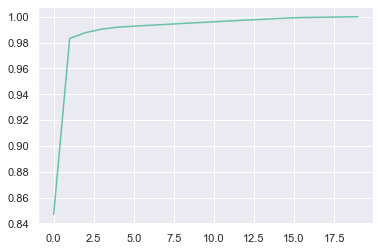

In [61]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [62]:
# percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
# plt.bar(x=range(1,21), height=percent_variance)
# plt.ylabel('Percentate of Variance Explained')
# plt.xlabel('Principal Component')
# plt.title('PCA Scree Plot')
# plt.show()

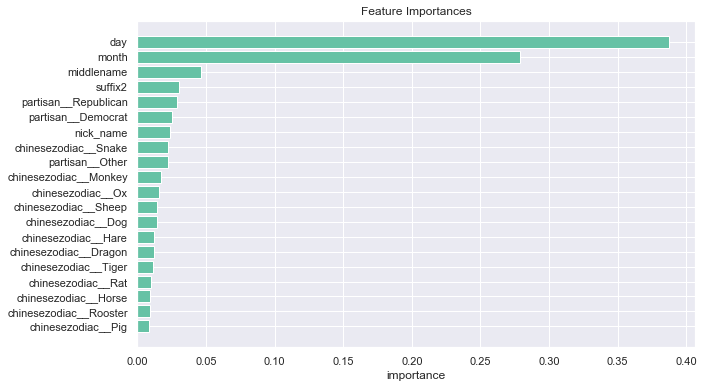

In [63]:
rfc_model = cv_rfc.best_estimator_
create_plot_of_feature_importances(rfc_model, X)

So this graph shows that using random forest, the most important features are by far the month and day that someone was born, followed by if someone has a middlename, a suffix attached to their name (if they are a junior or a third for example), followed by their party as well as the year they were born/Chinese zodiac.

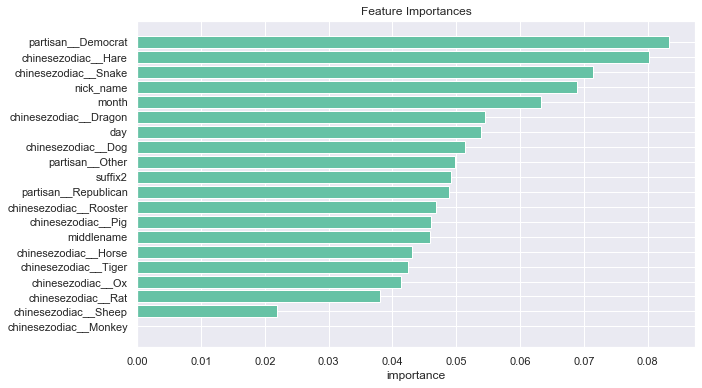

In [64]:
booster_model = booster_grid_search.best_estimator_
create_plot_of_feature_importances(booster_model, X)

Using the XGBoost model we can see that the features are a little bit more evenly spread out and unlike the Random Forest, the month and day are in the upper middle of the pack while if the member is a Hare, Monkey, or Ox are weighed far higher.


If you look at our classification reports, these two classifiers were almost identical, with XGBoost having a slightly higher accuracy of 84.79%. 

## **Future Work**

For future work for my dataset I would love to find more demographics and descriptive data such as religion, degrees held and jobs prior, and for very future work as Congress gets more representation from different types of people, I'd love to also add other features such as race and LGBTQIA+ information and see how each branch differs from the other.

Notes: 

-I was going to use a dataset that included religion data as well, however there were less than 200 rows of religion data, therefor I had to drop it.
-I had a lot of trial and error with datasets and I left the ones that I didn't end up using in my file.
-I was also going to do two other different projects completely and I left those documents in my file as well.